In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import calendar
from datetime import timedelta, datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from run import preprocessing
from catboost import CatBoostRegressor, Pool, cv
from tqdm import tqdm

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)


In [2]:
train = pd.read_excel('D:/X/Данные для Хакатона Кейс 3 To send.xlsx', sheet_name='train')
test = pd.read_excel('D:/X/Данные для Хакатона Кейс 3 To send.xlsx', sheet_name='test data')
side_data = pd.read_excel('D:/X/Данные для Хакатона Кейс 3 To send.xlsx', sheet_name='TV Viewing', skipfooter=2, skiprows=2, index_col=0, header=1)

In [3]:
train = train.drop('Break flight ID', axis=1)
test = test.drop('Break flight ID', axis=1)

In [4]:
side_data.index = range(1, 11)
side_data.loc[len(side_data) + 1] = pd.Series({2021: np.nan, 2022: np.nan, 2023: np.nan})
interpolated_data = pd.DataFrame(side_data.interpolate(method='cubicspline').apply(lambda x: x.mean(), axis=1), columns=['mean_viewing']).reset_index().rename(columns={'index': 'month', 'month': 'month'})


# Eda

# target

<Axes: >

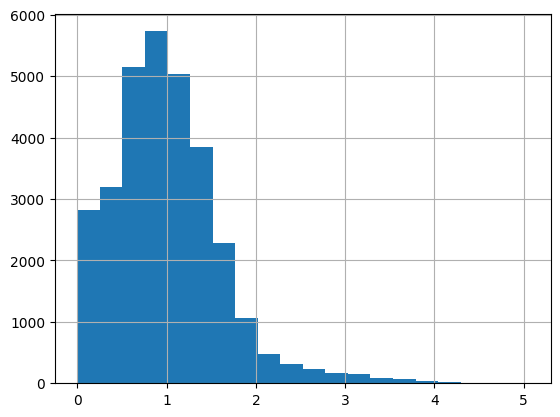

In [5]:
train['TVR Index'].hist(bins=20)

In [6]:
train['TVR Index'].describe()

count    30682.000000
mean         1.003735
std          0.609931
min          0.000000
25%          0.584708
50%          0.944528
75%          1.334333
max          5.052474
Name: TVR Index, dtype: float64

Есть нулевые значения.  Если придется логарифмировать,  то прибавим постоянное число.
Возможно это аномалия.

In [7]:
(train['TVR Index'] == 0).sum()

110

<Axes: >

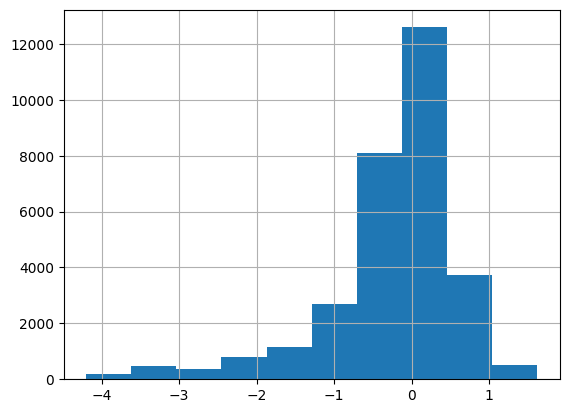

In [8]:
np.log(train[train['TVR Index'] != 0]['TVR Index']).hist()

# Date

In [9]:
def date_features(df):
    
    # df['is_leap'] = df['Date'].apply(lambda x: calendar.isleap(x.year)).astype(int)
    df['is_cristmas'] = df['Date'].apply(lambda x: 0 < x.day_of_year <=  8).astype(int)
    df['is_23_feb'] = df['Date'].apply(lambda x: x.day_of_year == 54).astype(int)
    df['is_8_march'] = df['Date'].apply(lambda x: x.day_of_year == 68).astype(int)   
    df['is_1_may'] = df['Date'].apply(lambda x: x.day_of_year == 122).astype(int)
    df['is_9_may'] = df['Date'].apply(lambda x: x.day_of_year == 130).astype(int)
    df['is_12_june'] = df['Date'].apply(lambda x: x.day_of_year == 164).astype(int)
    df['is_4_nov'] = df['Date'].apply(lambda x: x.day_of_year == 308).astype(int)
    df['is_weekend'] = df['Date'].apply(lambda x: 5 <= x.day_of_week <= 6).astype(int)

    
    return df

# Break flight ID

Колонка с уникальными значениями вряд-ли пригодится

# Break flight start | Break flight end	

In [10]:
def break_flight_features(df):
    
    def to_sec(break_flight_time):
        res = int(break_flight_time.hour) * 3600 + int(break_flight_time.minute) * 60 + int(break_flight_time.second)
        return res
        
    df = df.copy()
    
    df['Break flight start'] = df['Break flight start'].apply(lambda x: to_sec(x))
    df['Break flight end'] = df['Break flight end'].apply(lambda x: to_sec(x))
    df['Block_duration'] = df['Break flight end'] - df['Break flight start']
    df.loc[df['Block_duration'] < 0, 'Block_duration'] += 24 * 3600  


    
    df['Programme flight start'] = df['Programme flight start'].apply(lambda x: to_sec(x))
    df['Programme flight end'] = df['Programme flight end'].apply(lambda x: to_sec(x))
    df['Programme_duration'] = df['Programme flight end'] - df['Programme flight start']
    df.loc[df['Programme_duration'] < 0, 'Programme_duration'] += 24 * 3600  

    df['hour'] = df['Break flight start'].apply(lambda x: x.hour)

    return df


# Break content

<Axes: >

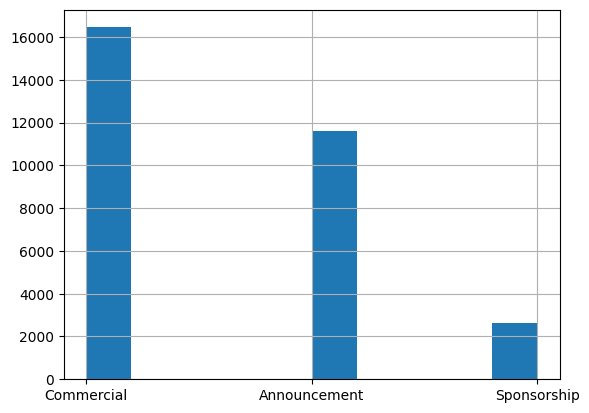

In [11]:
train['Break content'].hist()

# Break distribution	

In [12]:
train.head(4)

,TVR Index,Date,Break flight start,Break flight end,Break content,Break distribution,Programme,Programme flight start,Programme flight end,Programme category,Programme genre
0,0.614693,2023-01-02,08:17:33,08:21:40,Commercial,Network,"Telekanal ""Dobroe utro""",08:00:13,10:00:14,Morning airplay,Entertainment programs
1,0.869565,2023-01-02,08:34:45,08:38:52,Commercial,Network,"Telekanal ""Dobroe utro""",08:00:13,10:00:14,Morning airplay,Entertainment programs
2,0.989505,2023-01-02,08:52:19,08:56:23,Commercial,Network,"Telekanal ""Dobroe utro""",08:00:13,10:00:14,Morning airplay,Entertainment programs
3,0.884558,2023-01-02,08:56:31,08:57:28,Announcement,Network,"Telekanal ""Dobroe utro""",08:00:13,10:00:14,Morning airplay,Entertainment programs


<Axes: >

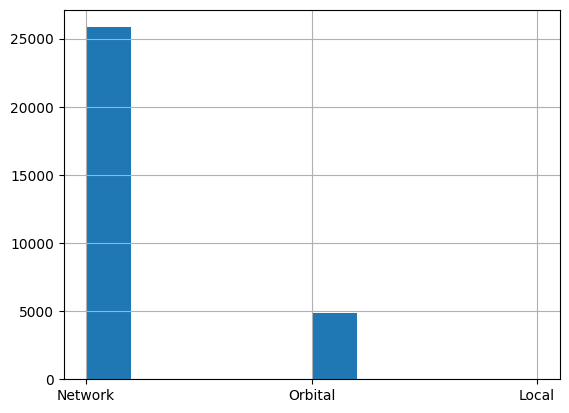

In [13]:
train['Break distribution'].hist()

# Programme

In [14]:
category_programmes_count_by_genre = train.groupby('Programme genre').agg({
                                                                            'Programme category': 'nunique', 
                                                                            'Programme': 'nunique'
                                                                            }).reset_index()

In [15]:
category_programmes_count_by_genre

,Programme genre,Programme category,Programme
0,Educational program,2,3
1,Entertainment programs,7,15
2,Musical programs,1,1
3,News,1,2
4,Social-political programs,2,5


# Side data
Среднее количество просмотров по месяцам

In [16]:
side_data = pd.read_excel('D:/X/Данные для Хакатона Кейс 3 To send.xlsx', sheet_name='TV Viewing', skipfooter=2, skiprows=2, index_col=0, header=1)

In [17]:
side_data

,2021,2022,2023
Jan,327.924500,327.759667,319.902000
Feb,315.605500,329.407333,310.317167
Mar,302.231333,316.343000,298.144667
Apr,280.771333,296.078667,276.041667
May,265.527167,282.549833,263.562000
Jun,255.598000,260.931500,257.940000
Jul,256.821333,256.654500,252.891167
Aug,260.952667,259.474833,253.577500
Sep,274.169333,277.913833,262.384000
Oct,290.561000,291.953333,281.895167


<Axes: >

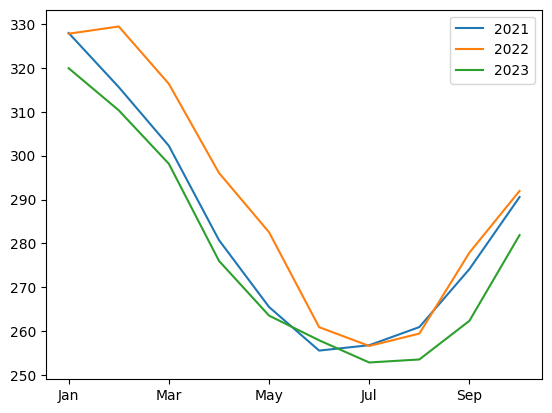

In [18]:
side_data.plot()

Похоже на синусоиду. Проинтерполируем по куб. спинам

In [19]:
side_data

,2021,2022,2023
Jan,327.924500,327.759667,319.902000
Feb,315.605500,329.407333,310.317167
Mar,302.231333,316.343000,298.144667
Apr,280.771333,296.078667,276.041667
May,265.527167,282.549833,263.562000
Jun,255.598000,260.931500,257.940000
Jul,256.821333,256.654500,252.891167
Aug,260.952667,259.474833,253.577500
Sep,274.169333,277.913833,262.384000
Oct,290.561000,291.953333,281.895167


In [20]:
side_data.index = range(1, 11)
side_data.loc[len(side_data) + 1] = pd.Series({2021: np.nan, 2022: np.nan, 2023: np.nan})

In [21]:
side_data

,2021,2022,2023
1,327.924500,327.759667,319.902000
2,315.605500,329.407333,310.317167
3,302.231333,316.343000,298.144667
4,280.771333,296.078667,276.041667
5,265.527167,282.549833,263.562000
6,255.598000,260.931500,257.940000
7,256.821333,256.654500,252.891167
8,260.952667,259.474833,253.577500
9,274.169333,277.913833,262.384000
10,290.561000,291.953333,281.895167


<Axes: >

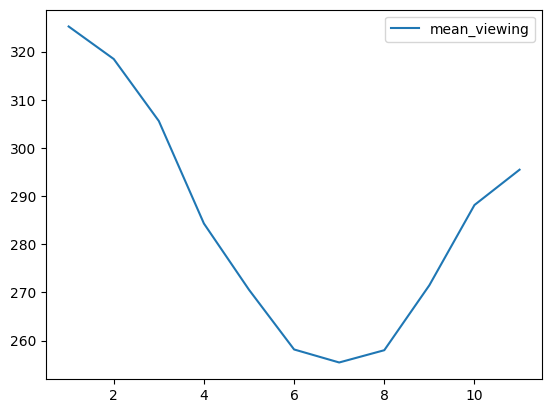

In [22]:
pd.DataFrame(side_data.interpolate(method='cubicspline').apply(lambda x: x.mean(), axis=1), columns=['mean_viewing']).plot()

# Naive

# Greed

In [23]:
train, test = preprocessing(train, test, interpolated_data)
train = train.merge(interpolated_data, on='month')
test = test.merge(interpolated_data, on='month')

train['count_break_hours_mean_viewing'] = train['count_break_hours'] / train['mean_viewing']
test['count_break_hours_mean_viewing'] = test['count_break_hours'] / test['mean_viewing']

D:\X\run.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daypart_break_stats = df.groupby('part_of_day_break_start')['hour_break_start'].agg(mean_break_hours='mean',
D:\X\run.py:101: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  daypart_break_stats = df.groupby('part_of_day_break_start')['hour_break_start'].agg(mean_break_hours='mean',


In [24]:
X_train = train[train['month'] != 10].drop('TVR Index', axis=1).drop('Date', axis=1)
y_train = train[train['month'] != 10]['TVR Index']

In [25]:
X_val = train[train['month'] == 10].drop('TVR Index', axis=1).drop('Date', axis=1)
y_val = train[train['month'] == 10]['TVR Index']

In [26]:
X_train.columns

Index(['holiday', 'Block_duration', 'Programme_duration',
       'Block_Programme_ratio', 'month', 'part_of_day_break_start',
       'part_of_day_programme_start', 'part_of_day_programme_end',
       'mean_break_hours', 'median_break_hours', 'count_break_hours',
       'is_weekend', 'mean_viewing', 'count_break_hours_mean_viewing'],
      dtype='object')

In [27]:
def mean_absolute_percentage_error_castom(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [28]:
cat_cols = [
            'part_of_day_programme_start',
            'part_of_day_programme_end',
            'holiday',
            'month',
            # 'hour_break_start',
            'part_of_day_break_start',
            # 'hour_programme_start',
            'part_of_day_programme_start',
            # 'hour_programme_end',
            'part_of_day_programme_end',
             # 'is_cristmas',
                # 'is_23_feb',
                # 'is_8_march',
                # 'is_1_may',
                # 'is_9_may',
                # 'is_12_june',
                # 'is_4_nov',
                'is_weekend'

    
           
           ]
cat_indices = [X_train.columns.tolist().index(i) for i in cat_cols]


In [29]:
X_train.columns

Index(['holiday', 'Block_duration', 'Programme_duration',
       'Block_Programme_ratio', 'month', 'part_of_day_break_start',
       'part_of_day_programme_start', 'part_of_day_programme_end',
       'mean_break_hours', 'median_break_hours', 'count_break_hours',
       'is_weekend', 'mean_viewing', 'count_break_hours_mean_viewing'],
      dtype='object')

In [30]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterGrid


# Определение параметров для GridSearch
param_grid = {
    'iterations': [200, 400],
    'depth': [10, 12],
    'learning_rate': [0.001, 0.01, 0.05, 0.1]
}

# Создание TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Создание объекта Pool для CatBoost
train_pool = Pool(X_train, label=y_train, cat_features=cat_indices)

best_mape = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    cat_model = CatBoostRegressor(cat_features=cat_indices, loss_function='MAPE', thread_count=-1, random_seed=55, **params)
    
    for i, (train_index, val_index) in enumerate(tqdm(tscv.split(X_train), total=tscv.get_n_splits())):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        cat_model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), verbose=0, plot=False, early_stopping_rounds=10)

        y_val_pred = cat_model.predict(X_val_fold)
        mape = mean_absolute_percentage_error(y_val_fold, y_val_pred)
        print(mape)
        if mape < best_mape:
            best_mape = mape
            best_params = params

# Вывод результатов
print("Best parameters found: ", best_params)
print("Lowest MAPE found: ", best_mape)

# Использование лучших параметров для обучения модели
final_cat_model = CatBoostRegressor(cat_features=cat_indices, **best_params)
final_cat_model.fit(X_train, y_train, verbose=0)



 20%|████████████████▊                                                                   | 1/5 [00:04<00:16,  4.18s/it]

1.5497305959674685


 40%|█████████████████████████████████▌                                                  | 2/5 [00:10<00:15,  5.31s/it]

1.1764839656925925


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:17<00:12,  6.03s/it]

1.624538905216111


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:24<00:06,  6.50s/it]

0.7483043471471497


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:32<00:00,  6.47s/it]


1.7571177648758047


 20%|████████████████▊                                                                   | 1/5 [00:05<00:22,  5.52s/it]

0.7050069004834303


 40%|█████████████████████████████████▌                                                  | 2/5 [00:11<00:17,  5.81s/it]

0.6038258012265983


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:18<00:12,  6.36s/it]

0.6221508044961469


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:25<00:06,  6.78s/it]

0.40084351563159776


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:34<00:00,  6.84s/it]


0.6643338612334952


 20%|████████████████▊                                                                   | 1/5 [00:02<00:09,  2.25s/it]

0.5427753717316196


 40%|█████████████████████████████████▌                                                  | 2/5 [00:07<00:12,  4.09s/it]

0.44467215903718665


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:10<00:06,  3.42s/it]

0.4596949290575394


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:15<00:04,  4.27s/it]

0.3050132208788457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.78s/it]


0.4956203914163655


 20%|████████████████▊                                                                   | 1/5 [00:01<00:04,  1.08s/it]

0.49725659216387735


 40%|█████████████████████████████████▌                                                  | 2/5 [00:04<00:06,  2.24s/it]

0.40843895978744393


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:06<00:04,  2.20s/it]

0.4947132773606682


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:09<00:02,  2.72s/it]

0.3085865989730184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.29s/it]


0.5141807533680385


 20%|████████████████▊                                                                   | 1/5 [00:09<00:37,  9.41s/it]

1.3548720301037875


 40%|█████████████████████████████████▌                                                  | 2/5 [00:21<00:33, 11.19s/it]

1.0514867843571811


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:42<00:31, 15.50s/it]

1.3986818662449652


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:05<00:18, 18.57s/it]

0.6658565668609141


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:27<00:00, 17.42s/it]


1.5130005780782527


 20%|████████████████▊                                                                   | 1/5 [00:12<00:49, 12.48s/it]

0.5570918011220548


 40%|█████████████████████████████████▌                                                  | 2/5 [00:23<00:34, 11.63s/it]

0.5407904106166745


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:38<00:26, 13.28s/it]

0.4717602018336878


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:58<00:16, 16.01s/it]

0.3403270075734303


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:11<00:00, 14.28s/it]


0.5876914269197318


 20%|████████████████▊                                                                   | 1/5 [00:02<00:10,  2.63s/it]

0.5427753717316196


 40%|█████████████████████████████████▌                                                  | 2/5 [00:14<00:24,  8.20s/it]

0.4349995250612373


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:17<00:11,  5.77s/it]

0.4596949290575394


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:25<00:06,  6.53s/it]

0.3050132208788457


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.76s/it]


0.4956203914163655


 20%|████████████████▊                                                                   | 1/5 [00:01<00:05,  1.32s/it]

0.49725659216387735


 40%|█████████████████████████████████▌                                                  | 2/5 [00:04<00:07,  2.55s/it]

0.40843895978744393


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:07<00:04,  2.48s/it]

0.4947132773606682


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:11<00:03,  3.04s/it]

0.3085865989730184


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.57s/it]


0.5141807533680385


 20%|████████████████▊                                                                   | 1/5 [00:08<00:33,  8.40s/it]

1.5532011694133863


 40%|█████████████████████████████████▌                                                  | 2/5 [00:18<00:27,  9.16s/it]

1.168906044324999


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:28<00:19,  9.82s/it]

1.6364494293696281


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:41<00:10, 10.84s/it]

0.753695260152815


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:55<00:00, 11.04s/it]


1.7588792239018392


 20%|████████████████▊                                                                   | 1/5 [00:11<00:46, 11.50s/it]

0.7677641195587661


 40%|█████████████████████████████████▌                                                  | 2/5 [00:23<00:35, 11.86s/it]

0.571771027219762


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:36<00:24, 12.12s/it]

0.6297212776558412


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:50<00:13, 13.22s/it]

0.40582420025988175


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:06<00:00, 13.31s/it]


0.7229449452176153


 20%|████████████████▊                                                                   | 1/5 [00:05<00:20,  5.05s/it]

0.5085130149448348


 40%|█████████████████████████████████▌                                                  | 2/5 [00:15<00:25,  8.51s/it]

0.4654931153104516


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:23<00:15,  7.91s/it]

0.47855966423246904


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:30<00:07,  7.66s/it]

0.3583295424487944


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:37<00:00,  7.55s/it]


0.5237637934605852


 20%|████████████████▊                                                                   | 1/5 [00:02<00:11,  2.86s/it]

0.47300363275663165


 40%|█████████████████████████████████▌                                                  | 2/5 [00:06<00:10,  3.56s/it]

0.4670727684192797


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:09<00:06,  3.15s/it]

0.46192587041416844


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:14<00:03,  3.95s/it]

0.3246939959895179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.57s/it]


0.6723526204240301


 20%|████████████████▊                                                                   | 1/5 [00:17<01:09, 17.43s/it]

1.3644178713373945


 40%|█████████████████████████████████▌                                                  | 2/5 [00:37<00:57, 19.13s/it]

1.0327311161387291


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:01<00:42, 21.44s/it]

1.4308448112678605


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:28<00:23, 23.44s/it]

0.6732579727865854


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:58<00:00, 23.73s/it]


1.5183897851265167


 20%|████████████████▊                                                                   | 1/5 [00:21<01:25, 21.37s/it]

0.6294099080118816


 40%|█████████████████████████████████▌                                                  | 2/5 [00:43<01:05, 21.94s/it]

0.48357507996426913


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:06<00:44, 22.48s/it]

0.49526590319613084


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:34<00:24, 24.51s/it]

0.34950168781061713


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:58<00:00, 23.73s/it]


0.6184826512276023


 20%|████████████████▊                                                                   | 1/5 [00:05<00:20,  5.16s/it]

0.5085130149448348


 40%|█████████████████████████████████▌                                                  | 2/5 [00:22<00:37, 12.41s/it]

0.4550961411617215


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:30<00:20, 10.18s/it]

0.47855966423246904


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:37<00:09,  9.00s/it]

0.3583295424487944


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:44<00:00,  8.95s/it]


0.5237637934605852


 20%|████████████████▊                                                                   | 1/5 [00:03<00:12,  3.01s/it]

0.47300363275663165


 40%|█████████████████████████████████▌                                                  | 2/5 [00:07<00:11,  3.67s/it]

0.4670727684192797


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:10<00:06,  3.31s/it]

0.46192587041416844


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:15<00:04,  4.22s/it]

0.3246939959895179


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.78s/it]

0.6723526204240301
Best parameters found:  {'depth': 10, 'iterations': 200, 'learning_rate': 0.05}
Lowest MAPE found:  0.3050132208788457


In [31]:
# Оценка на валидационном наборе
y_val_pred = final_cat_model.predict(X_val)
mape = mean_absolute_percentage_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
print(f'Validation MAPE: {mape}, MAE: {mae}')


Validation MAPE: 0.5678786363460829, MAE: 0.25858692345329526


In [69]:
best_params

{'depth': 10, 'iterations': 500, 'learning_rate': 0.05}

In [ ]:
{'depth': 10, 'iterations': 200, 'learning_rate': 0.05}

In [40]:
cat_cols = [
            'part_of_day_programme_start',
            'part_of_day_programme_end',
            'holiday',
            'month',
            # 'hour_break_start',
            'part_of_day_break_start',
            # 'hour_programme_start',
            'part_of_day_programme_start',
            # 'hour_programme_end',
            'part_of_day_programme_end',
             # 'is_cristmas',
             #    'is_23_feb',
             #    'is_8_march',
             #    'is_1_may',
             #    'is_9_may',
             #    'is_12_june',
             #    'is_4_nov',
                'is_weekend'

   
           
           ]
best_params = {'depth': 10, 'iterations': 500, 'learning_rate': 0.05}
cat_indices = [X_train.columns.tolist().index(i) for i in cat_cols]

cat_model = CatBoostRegressor(cat_features=cat_indices, verbose=0, random_seed=55, loss_function='MAPE', thread_count=-1, **best_params)
report = []
for i, (train_index, val_index) in enumerate(tqdm(tscv.split(X_train), total=tscv.get_n_splits())):
    print(f'Fold {i}')
    
    X_train_, X_val_ = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_, y_val_ = y_train.iloc[train_index], y_train.iloc[val_index]

    cat_model.fit(X_train, y_train)
    y_pred = cat_model.predict(X_val_)
    
    # y_pred = np.exp(y_pred) - 1
    mape = mean_absolute_percentage_error(y_val_, y_pred)
    mape_c = mean_absolute_percentage_error_castom(y_val_, y_pred)
    mae = mean_absolute_error(y_val_, y_pred)
    print(f'MAPE: {mape}, MAE: {mae}')

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Fold 0


 20%|████████████████▊                                                                   | 1/5 [00:22<01:31, 22.80s/it]

MAPE: 0.25630843848399415, MAPE_castom: 25.630843848399415, MAE: 0.2006464085643484
Fold 1


 40%|█████████████████████████████████▌                                                  | 2/5 [00:49<01:15, 25.15s/it]

MAPE: 0.24961531673790427, MAPE_castom: 24.961531673790425, MAE: 0.18402936784911375
Fold 2


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:14<00:49, 24.86s/it]

MAPE: 0.2592245119488501, MAPE_castom: 25.92245119488501, MAE: 0.18707292317717003
Fold 3


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:42<00:26, 26.07s/it]

MAPE: 0.2089554440787493, MAPE_castom: 20.89554440787493, MAE: 0.15808924511788428
Fold 4


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:06<00:00, 25.34s/it]

MAPE: 0.290315526476579, MAPE_castom: 29.0315526476579, MAE: 0.19309584170554694


In [54]:
cat_model.save_model('D:/X/cat_nodel.cbm')

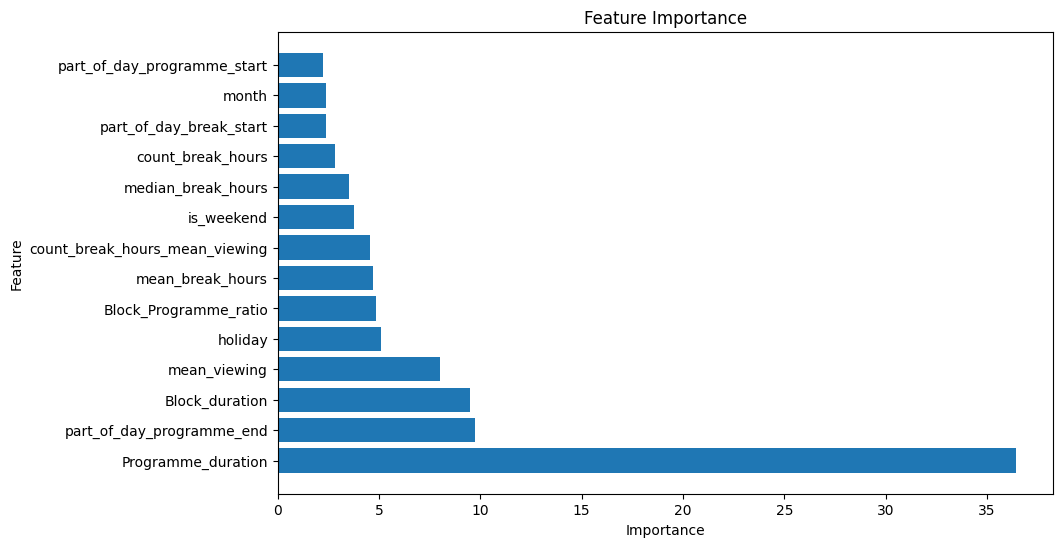

In [49]:
import matplotlib.pyplot as plt

# Получение важности признаков
feature_importance = cat_model.get_feature_importance(prettified=True)

# Визуализация
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature Id'], feature_importance['Importances'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

# Submit

In [58]:
test = test.drop('Date', axis=1)

KeyError: "['Date'] not found in axis"

In [61]:
pred = cat_model.predict(test)

In [63]:
sub = pd.read_excel('D:/X/Данные для Хакатона Кейс 3 To send.xlsx', sheet_name='test data')

In [65]:
sub['TVR Index Forecast'] = pred

In [67]:
sub.to_csv('./sub.csv', index_label=False)